In [1]:
import sys

sys.path.append('..')

from LoadData2 import loadNbackEmoidAgesScansAndGenders, loadMeta

pncDir = '../../PNC_Good'

keys, nbackTs, emoidTs, ages = loadNbackEmoidAgesScansAndGenders(loadMeta(f'{pncDir}/MegaMeta2.pkl'))

print(nbackTs.shape)
print(emoidTs.shape)
print(ages.shape)
print(ages[0:10])

(804, 264, 231)
(804, 264, 210)
(804,)
[ 9.66666667 15.58333333 15.83333333 20.16666667 11.41666667 11.58333333
  9.41666667 17.5        15.25        9.58333333]


In [2]:
# Functional connectivity

from LoadData2 import getFC
import numpy as np

nbackP = getFC(nbackTs)
emoidP = getFC(emoidTs)

print(nbackP.shape)
print(emoidP.shape)

(804, 264, 264)
(804, 264, 264)


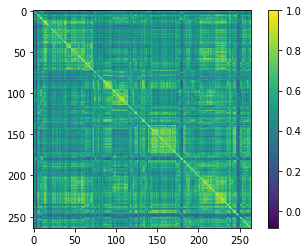

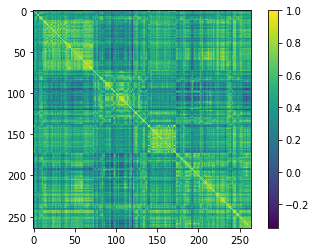

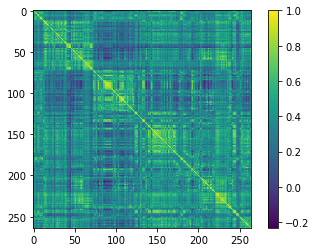

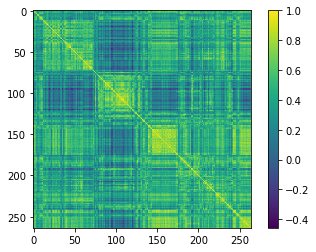

In [3]:
import matplotlib.pyplot as plt

plt.imshow(nbackP[0])
plt.colorbar()
plt.show()

plt.imshow(nbackP[1])
plt.colorbar()
plt.show()

plt.imshow(emoidP[0])
plt.colorbar()
plt.show()

plt.imshow(emoidP[1])
plt.colorbar()
plt.show()

In [4]:
# Convert to torch

import torch

nbackP_t = torch.from_numpy(nbackP).reshape(804,264*264).float().cuda()
emoidP_t = torch.from_numpy(emoidP).reshape(804,264*264).float().cuda()
feat_t = torch.cat([nbackP_t, emoidP_t], dim=1)
ages_t = torch.from_numpy(ages).float().cuda()

print('Complete')

Complete


In [5]:
# Run MLP

import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, delta):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2*264*264,100).float().cuda()
        self.fc2 = nn.Linear(100,1).float().cuda()
        self.delta = delta

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def loss(self, pred, truth):
        cond = torch.abs(pred-truth)
        idcs = cond > self.delta
        case0 = 0.5*cond**2
        case1 = self.delta*cond-0.5*self.delta**2
        case0[idcs] = case1[idcs]
        return torch.mean(case0)

mlp = MLP(1)
optim = torch.optim.Adam(mlp.parameters(), lr=5e-5, weight_decay=0.2)

nEpoch = 3000
pPrint = 200

# feat_t_train = torch.cat([nbackP_t[0:600], emoidP_t[0:600]], dim=1)
# ages_t_train = ages_t[0:600]

for epoch in range(nEpoch):
    optim.zero_grad()
    pred = mlp(feat_t).flatten()
    loss = mlp.loss(pred, ages_t)
    loss.backward()
    optim.step()
    if epoch % pPrint == 0 or epoch == nEpoch-1:
        print(f'epoch {epoch} loss={loss}')

print('Completed MLP')

epoch 0 loss=14.475053787231445
epoch 200 loss=1.0401818752288818
epoch 400 loss=0.791437566280365
epoch 600 loss=0.731939971446991
epoch 800 loss=0.6860380172729492
epoch 1000 loss=0.6252667903900146
epoch 1200 loss=0.55600506067276
epoch 1400 loss=0.5510581135749817
epoch 1600 loss=0.5377728343009949


KeyboardInterrupt: 

In [7]:
import numpy as np

roiMap1 = np.zeros(265,dtype='int')
roiMap2 = np.zeros(265,dtype='int')
revMap2 = np.zeros(264,dtype='int')
roiNames = {}
borders1 = []
borders2 = []

with open('../../PNC/PP264_template.csv', 'r') as f:
    lines = f.readlines()
    for i in range(2,len(lines)):
        line = lines[i].split(',')
        area = int(line[11])
        r1 = int(line[0])
        r2 = int(line[1])
        name = line[14].strip()
        roiMap1[r1] = area
        roiMap2[r2] = area
        roiNames[area] = name
        revMap2[r1-1] = r2-1
#         print([area, r1, r2, name])

last1 = roiMap1[1]
last2 = roiMap2[1]
for i in range(2,265):
    if roiMap1[i] != last1:
        borders1.append(i)
        last1 = roiMap1[i]
    if roiMap2[i] != last2:
        borders2.append(i)
        last2 = roiMap2[i]
    
borders1 = [0] + borders1 + [264]
print(borders1)
print(borders2)

[0, 31, 36, 50, 63, 121, 126, 157, 182, 200, 213, 222, 233, 237, 264]
[13, 42, 47, 61, 74, 84, 86, 132, 133, 137, 138, 139, 140, 143, 174, 182, 186, 203, 221, 222, 235, 243, 247, 251, 253, 255, 256]


/home/anton/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


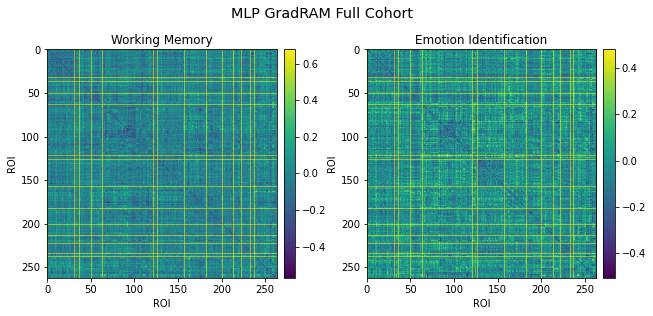

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def rearrange(p,idcs):
    return p[:,idcs][idcs]

mlp.zero_grad()
pred = mlp(feat_t).flatten()
loss = mlp.loss(pred[ages_t > 16], ages_t[ages_t > 16])
loss.backward()
ram = (mlp.fc2.weight.grad@mlp.fc1.weight).flatten()

fig, ax = plt.subplots(1,2,figsize=(10.5,4.2))
fig.suptitle('MLP GradRAM Full Cohort', y=1.02, fontsize='x-large')

color = 'yellow'

divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes('right', size='5%', pad=0.1)

im1 = ax[0].imshow(rearrange(ram[:264*264].reshape(264,264).detach().cpu().numpy(), revMap2))
for b in borders1:
    ax[0].plot([0,263],[b,b],color=color,linewidth=0.5)
    ax[0].plot([b,b],[0,263],color=color,linewidth=0.5)
ax[0].set_ylabel('ROI')
ax[0].set_xlabel('ROI')
ax[0].set_title(f'Working Memory')
ax[0].set_xlim(0,263)
ax[0].set_ylim(262,0)

divider = make_axes_locatable(ax[1])
cax2 = divider.append_axes('right', size='5%', pad=0.1)

im2 = ax[1].imshow(rearrange(ram[264*264:].reshape(264,264).detach().cpu().numpy(), revMap2))
for b in borders1:
    ax[1].plot([0,263],[b,b],color=color,linewidth=0.5)
    ax[1].plot([b,b],[0,263],color=color,linewidth=0.5)
ax[1].set_ylabel('ROI')
ax[1].set_xlabel('ROI')
ax[1].set_title(f'Emotion Identification')
ax[1].set_xlim(0,263)
ax[1].set_ylim(262,0)

fig.colorbar(im1, cax=cax1, orientation='vertical')
fig.colorbar(im2, cax=cax2, orientation='vertical')

fig.show()
fig.savefig('../../Work/Explainer/GradRAM_MLP.png', format='png', bbox_inches='tight')

In [6]:
res = mlp(feat_t).flatten().detach().cpu().numpy()
mae = np.mean(np.abs(res-ages))

print(f'Average mae {mae}')

Average mae 0.8636451969494668


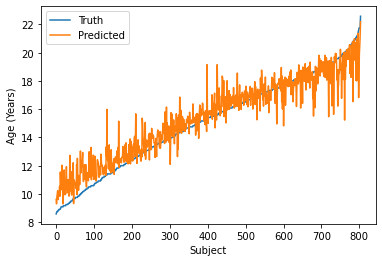

In [9]:
import matplotlib.pyplot as plt

idcs = np.argsort(ages)
y = ages[idcs]
yhat = res[idcs]

plt.plot(y, label='Truth')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.xlabel('Subject')
plt.ylabel('Age (Years)')
plt.show()

In [14]:
# Run GCN

from torch_geometric.nn.dense import DenseGCNConv

def normalize(A):
    if A.shape[0] != A.shape[1]:
        raise Exception("Bad A shape")
    d = torch.sum(A,dim=1)**0.5
    return ((A/d).T/d).T

# Cosine similarity

def cosineSim(a, b):
    nB = a.shape[0]
    e = torch.einsum('ai,bi->ab',a,b)
    aa = torch.einsum('ai,ai->a',a,a)**0.5
    bb = torch.einsum('bi,bi->b',b,b)**0.5
    e /= aa.unsqueeze(1)
    e /= bb.unsqueeze(1).T
    return normalize(e-torch.eye(nB).float().cuda())

class GCN(nn.Module):
    def __init__(self, delta):
        super(GCN, self).__init__()
        self.gc1 = DenseGCNConv(2*264*264,100).float().cuda()
        self.gc2 = DenseGCNConv(100,1).float().cuda()
        self.delta = delta
        self.loss = nn.MSELoss()

    def forward(self, x):
        A = x[0]
        z = x[1]
        a = F.relu(self.gc1(z,A))
        a = self.gc2(a,A)
        return a
    
#     def loss(self, pred, truth):
#         cond = torch.abs(pred-truth)
#         idcs = cond > self.delta
#         case0 = 0.5*cond**2
#         case1 = self.delta*cond-0.5*self.delta**2
#         case0[idcs] = case1[idcs]
#         return torch.mean(case0)
    
# Atrain = cosineSim(feat_t_train, feat_t_train)
feat_t = torch.cat([nbackP_t, emoidP_t], dim=1)
A = cosineSim(feat_t, feat_t)

gcn = GCN(1)
optim = torch.optim.Adam(gcn.parameters(), lr=5e-5, weight_decay=0.2)

nEpoch = 5000
pPrint = 200

for epoch in range(nEpoch):
    optim.zero_grad()
    pred = gcn([A, feat_t]).flatten()
    loss = gcn.loss(pred, ages_t)
    loss.backward()
    optim.step()
    if epoch % pPrint == 0 or epoch == nEpoch-1:
        print(f'epoch {epoch} loss={loss}')

print('Completed GCN')

epoch 0 loss=241.28182983398438
epoch 200 loss=7.721500396728516
epoch 400 loss=6.499478816986084
epoch 600 loss=5.746682643890381
epoch 800 loss=5.067922592163086
epoch 1000 loss=4.524860858917236
epoch 1200 loss=4.148291110992432
epoch 1400 loss=3.8278136253356934
epoch 1600 loss=3.6534430980682373
epoch 1800 loss=3.446499824523926
epoch 2000 loss=3.255681037902832
epoch 2200 loss=3.2039146423339844
epoch 2400 loss=3.0659804344177246
epoch 2600 loss=2.9334893226623535
epoch 2800 loss=2.8169617652893066
epoch 3000 loss=2.714768171310425
epoch 3200 loss=2.6422221660614014
epoch 3400 loss=2.5503385066986084
epoch 3600 loss=2.4874212741851807
epoch 3800 loss=2.4984405040740967
epoch 4000 loss=2.3553359508514404
epoch 4200 loss=2.2883169651031494
epoch 4400 loss=3.297536849975586
epoch 4600 loss=2.192004442214966
epoch 4800 loss=2.141414165496826
epoch 4999 loss=2.0816285610198975
Completed GCN


In [15]:
res = gcn([A, feat_t]).flatten().detach().cpu().numpy()
mae = np.mean(np.abs(res-ages))

print(f'Average mae {mae}')

Average mae 1.1512670540691015


In [55]:
# Save model for explainer

torch.save(gcn.state_dict(), '../../Work/Explainer/GCN_NbackEmoid.pyt')

print('Complete')

In [61]:
import functools

def getDataForAgeRange(feat, ages, low, high):
    mask = torch.logical_and(ages > low, ages <= high)
    return feat[mask], ages[mask]

ageBoundaries = [8,12,14,16,18,23]
featGrps = []
ageGrps = []

for i in range(len(ageBoundaries)-1):
    f, a = getDataForAgeRange(feat_t, ages_t, ageBoundaries[i], ageBoundaries[i+1])
    featGrps.append(f)
    ageGrps.append(a)
    
print(functools.reduce(lambda n, grp: n+grp.shape[0], ageGrps, 0))

804


In [ ]:
class Explainer(nn.Module):
    def __init__(self, gcn, A, nGroups):
        super(Explainer, self).__init__()
        self.gcn = gcn
        self.A = A
        self.fmasks = []
        self.Amasks = []
        for i in range(nGroups):
            self.fmasks.append(nn.Parameter(torch.ones(2*264*264).float().cuda()))
            self.Amasks.append(nn.Parameter(torch.ones(A.shape).float().cuda()))
        self.fmasks = nn.ParameterList(self.fmasks)
        self.Amasks = nn.ParameterList(self.Amasks)

    def forward(self, xs):
        preds = []
        for i in range(len(xs)):
            fmask = torch.sigmoid(self.fmasks[i])
            Amask = torch.sigmoid(self.Amasks[i])
            preds.append(gcn[self.A*Amask, xs[i]*fmask].flatten())
        return preds

    def loss(self, pred, truth, model):
        fmask = torch.sigmoid(self.fmask)
        pred_loss = model.loss(pred, truth)
        feat_size_loss = torch.mean(fmask)
        feat_ent_loss = torch.mean(-fmask*torch.log(fmask) - (1-fmask)*torch.log(1-fmask))
        return pred_loss + 75*feat_size_loss + 60*feat_ent_loss